# Data

In [1]:
# !mutil_stock_lstm.py

# Import

In [2]:
import sys
import warnings
# 屏蔽特定的 FutureWarning
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="Setting an item of incompatible dtype is deprecated and will raise"
)
sys.path.append(r"e:\pythonproject\pythonproject\code\trade_test")
from slave import *
from config import config
from LSTMAPI import LSTMPredictorAPI

# Parameters

In [3]:
config_info = {
    "index": {
        "irank": {
        }
    },
    "main": {
        "loss_p": -0.01,
        "profit_p": 0.02,
        "_alarm": {
            "clear": ['12:00'],
            "orders": ['23:00']
        },
        "_timer": {
            "orders": 60,
            "positions": 1
        },
    },
    "trade": {
        "amountusd": 10000,
        "apikey": "xxxxx",
        "apisets": {
            "bbo": "QUEUE",
            "count_cancel": 5,
            "iceberg": 10000,
            "offer_step": 1,
            "retry": 1,
            "timeInForce": "GTC"
        },
        "hold_time": 10,
        "leverage": 2,
        "orders_type": "BBO",
        "position_type": "BBO",
        "stop_iceberg": 10000,
        "stop_interval": 0.1,
    }
}


# Read

In [4]:
total_data = pd.read_csv("./data/total_data.csv")
total_data['t'] = total_data['t'] + 60000
total_data = total_data.set_index('t')
total_1h_data = pd.read_csv("./data/total_1h_data.csv")
total_1h_data = total_1h_data.set_index('t')

# index

In [5]:

class IRANK():

    def __init__(self, paras, algoid):
        self.paras = paras
        self.algoid = algoid
        self.total_data = total_data
        self.total_1h_data = total_1h_data  # 到时候判断是否要进入的时候，就用时间戳减去60000一分钟数据，然后看整除，是否能够整除进入到模型中去检验
        self.LSTMapi = LSTMPredictorAPI(model_path=None)
        self.predict_data = 0
        self.config = config
        self.calculate()

    def update(self, idx):
        target_prod = []

        if idx not in self.total_1h_data.index or idx - 150 * 60 * 60000 not in self.total_1h_data.index:
            return target_prod

        x_data = self.total_1h_data.loc[idx - 150 * 60 * 60000:idx]
        y_values = self.LSTMapi.main(x_data)
        self.predict_data = y_values

        if self.total_data['c'].loc[idx] < y_values:
            target_prod.append({'symbol': "c", 'side': 'BUY'})
        else:
            target_prod.append({'symbol': "c", 'side': 'SELL'})

        return target_prod

    def calculate(self):
        pass

In [6]:
irank = IRANK(config_info['index']['irank'], algoid='lstm_predict')

# Algo

In [7]:
class MAIN(SLAVE):

    def __init__(self):
        algoid, config, client, index = None, config_info, None, None
        self.config = config['main']
        self.irank = irank
        super().__init__(client=client, paras=config['trade'], algoid=algoid)

    def x_orders(self):
        order_time = HELPER.last_kline_time()
        target_prod = self.irank.update(order_time)
        if len(target_prod) == 0:
            return
        for s in target_prod:
            symbol = s["symbol"]
            if symbol in self.infos['positions'].keys() and self.infos['positions'][symbol] > 0:
                target_prod.remove(s)
        for s in target_prod:
            symbol = s["symbol"]
            if symbol not in self.caches:
                self.caches[symbol] = {}
                self.caches[symbol]['open_time'] = []
                self.caches[symbol]['open_price'] = []
                self.caches[symbol]['close_time'] = []
                self.caches[symbol]['close_price'] = []
            self.caches[symbol]['open_time'].append(order_time)
            self.caches[symbol]['open_price'].append(total_data[symbol].loc[order_time])
        self.slave_orders(target_prod)

    def x_positions(self):

        if self.infos['total_abs_positions'] == 0:
            return 1
        action_info = {}
        current_time = HELPER.last_ticker_time()
        for s in self.infos["positions"].keys():

            if self.infos['profits'][s] < self.config['loss_p'] * self.infos['abs_originals'][s]:
                action_info[s] = 'stop'

            elif self.infos['profits'][s] > self.config['profit_p'] * self.infos['abs_originals'][s]:
                action_info[s] = 'take_profit'

            elif current_time in total_1h_data.index:
                if self.infos["positions"][s] > 0 and irank.predict_data < HELPER.ticker_price(s):
                    action_info[s] = 'stop'

                elif self.infos['positions'][s] < 0 and irank.predict_data > HELPER.ticker_price(s):
                    action_info[s] = 'take_profit'

        if not action_info:
            return 0

        for s in action_info.keys():
            self.caches[s]['close_time'].append(current_time)
            self.caches[s]['close_price'].append(total_data[s].loc[current_time])
        result_cur = self.slave_positions(action_info)
        return result_cur

    # def x_clear(self):
    #     self.base_clear()

In [8]:
main = MAIN()

In [9]:
def job(day):
    result = []

    for idx in tqdm(day):
        HELPER.update(idx, total_data)
        main.base_infos()

        result_cur = main.x_positions()

        if type(result_cur) != int:
            result += result_cur

        main.base_infos()

        if main.infos['total_abs_positions'] == 0:
            main.x_orders()

    main.base_infos()
    result_cur = HELPER.profit(infos=main.infos, method="down_over20%")
    if result_cur is not None:
        if result_cur[0][1] == 0:
            # main.base_infos()
            # main.x_orders()
            return result

        result += result_cur
    return result

In [10]:
result = HELPER.driver(df=total_data, job=job, n_jobs=1,start='2025-01-01', end='2025-10-28')

100%|██████████| 431519/431519 [04:13<00:00, 1700.02it/s]


In [11]:
result_df = pd.DataFrame(result)
result_df

,0,1
0,1736236860000,-13.00000
1,1736240460000,23.00000
2,1736244060000,-46.00000
3,1736247660000,-5.00000
4,1736260620000,-105.00000
...,...,...
5964,1761566460000,-21.00000
5965,1761570060000,-28.00000
5966,1761573660000,75.00000
5967,1761574800000,-105.00000


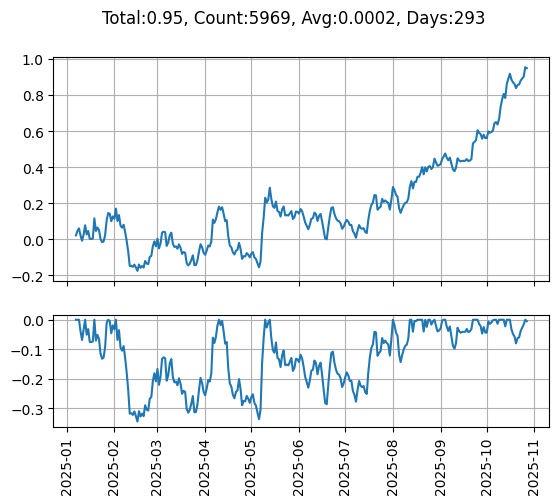

In [12]:
fig, axes, arr = PLOT.profit(result=result, amountusd=config_info['trade']['amountusd'], freq='D')